# Feature Summary
### Stock Price
`Price`: Date of the stock data (needs cleaning as the first two rows are headers).    
`Adj Close`: Adjusted closing price, accounting for events like dividends and splits.    
`Close`: Closing price of the stock at the end of the trading day.  
`High`: Highest price of the stock during the trading day.  
`Low`: Lowest price of the stock during the trading day.  
`Open`: Opening price of the stock at the start of the trading day.  
`Volume`: Number of shares traded during the day.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

google = pd.read_csv('googl_data_2020_2025.csv')
commodity = pd.read_csv('commodity_prices.csv')

# EDA

## Google Stock

In [2]:
google.head(10)

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00+00:00,68.18682098,68.43399811,68.43399811,67.32450104,67.42050171,27278000
3,2020-01-03 00:00:00+00:00,67.83010101,68.0759964,68.6875,67.36599731,67.40000153,23408000
4,2020-01-06 00:00:00+00:00,69.63805389,69.89050293,69.91600037,67.55000305,67.58149719,46768000
5,2020-01-07 00:00:00+00:00,69.50354767,69.75550079,70.17500305,69.57800293,70.02300262,34330000
6,2020-01-08 00:00:00+00:00,69.99825287,70.2519989,70.59249878,69.63150024,69.74099731,35314000
7,2020-01-09 00:00:00+00:00,70.73309326,70.98950195,71.43399811,70.51049805,71.09649658,33200000
8,2020-01-10 00:00:00+00:00,71.18992615,71.44799805,71.74700165,70.98000336,71.47350311,26258000
9,2020-01-13 00:00:00+00:00,71.74143219,72.00150299,72.0739975,71.26850128,71.76249695,30730000


In [3]:
# Drop the first 2 rows
google = google.drop(index=[0,1]).reset_index(drop=True)  # prevents the old index from being added as a new column

# Rename column "Price" to "Date"
google.rename(columns={'Price': 'Date'}, inplace=True)

In [4]:
# Print info
print(google.info())

# check for missing values
print('\nCheck for missing values:')
print(google.isnull().sum())

# check for duplicate values
print('\nCheck for duplicate value:')
print(google.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1258 non-null   object
 1   Adj Close  1258 non-null   object
 2   Close      1258 non-null   object
 3   High       1258 non-null   object
 4   Low        1258 non-null   object
 5   Open       1258 non-null   object
 6   Volume     1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB
None

Check for missing values:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Check for duplicate value:
False    1258
Name: count, dtype: int64


In [5]:
# Convert "Date" column to datetime, forcing errors to NaN
google['Date'] = pd.to_datetime(google['Date'], errors='coerce')

# Format to 'yyyy-mm-dd' datetime object type
google['Date'] = google['Date'].dt.date

# Convert back to datetime
google['Date'] = pd.to_datetime(google['Date'])

# Convert columns to numeric, forcing errors to NaN
google[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = google[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].apply(pd.to_numeric, errors='coerce')

# Check dataset again
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Adj Close  1258 non-null   float64       
 2   Close      1258 non-null   float64       
 3   High       1258 non-null   float64       
 4   Low        1258 non-null   float64       
 5   Open       1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [6]:
google.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2022-07-01 15:39:46.645468928,118.684965,119.075610,120.378055,117.722657,119.004592,3.308795e+07
min,2020-01-02 00:00:00,52.516125,52.706501,53.345501,50.443501,52.818501,9.312000e+06
25%,2021-04-02 00:00:00,93.608171,93.947502,95.272123,92.305002,93.832497,2.343938e+07
50%,2022-06-30 12:00:00,119.267639,119.699997,121.044502,118.626247,119.712502,2.943300e+07
75%,2023-10-01 06:00:00,140.598320,141.107998,142.101002,139.796120,140.996876,3.773515e+07
max,2024-12-31 00:00:00,196.660004,196.660004,201.419998,194.979996,197.250000,1.232000e+08
std,NaN,32.403071,32.453265,32.688266,32.248276,32.481362,1.461758e+07


C:\Users\HanDong\AppData\Local\Temp\ipykernel_14240\1262732184.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=google, x='Year', palette='viridis')


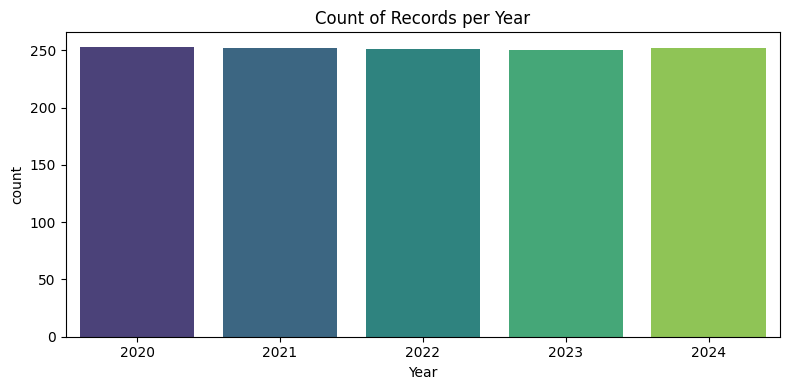

In [ ]:
# Create more features to analyse
google['Year'] = google['Date'].dt.year
google['Month'] = google['Date'].dt.month
google['Day'] = google['Date'].dt.day

# Count plot (pie chart style) for the 'Year' column to inspect distribution over time
plt.figure(figsize=(8, 4))
sns.countplot(data=google, x='Year', palette='viridis')
plt.title('Count of Records per Year')
plt.tight_layout()
plt.show()

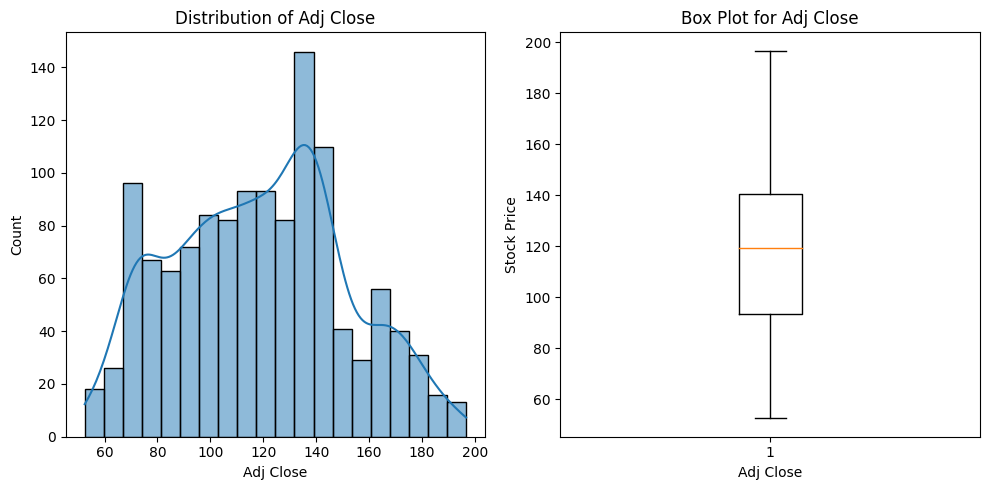

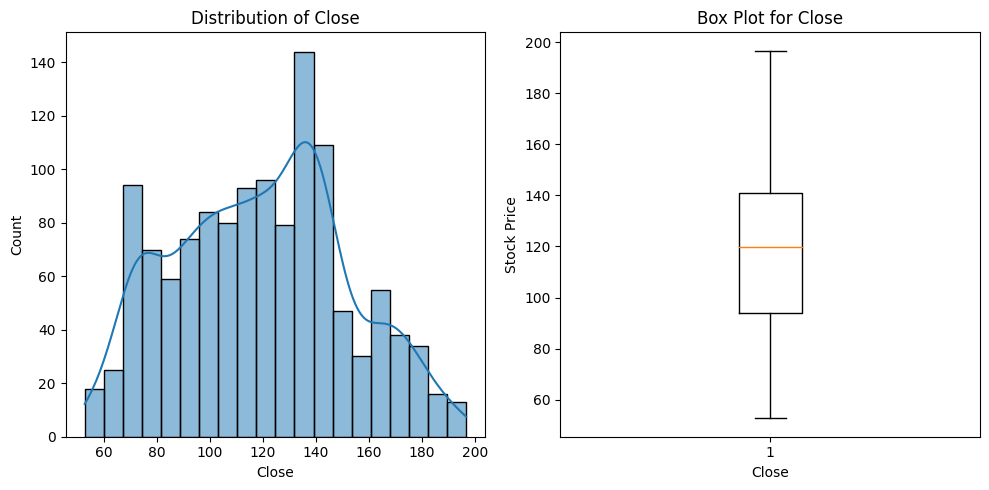

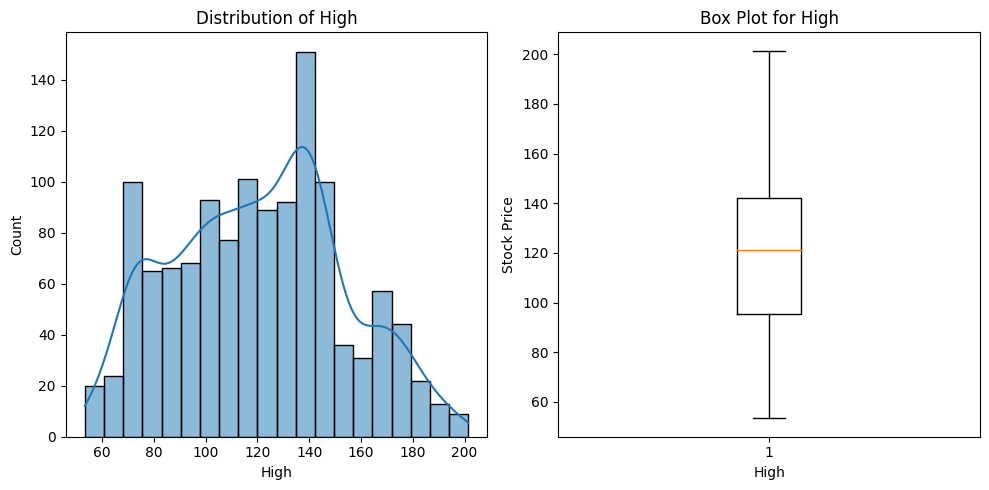

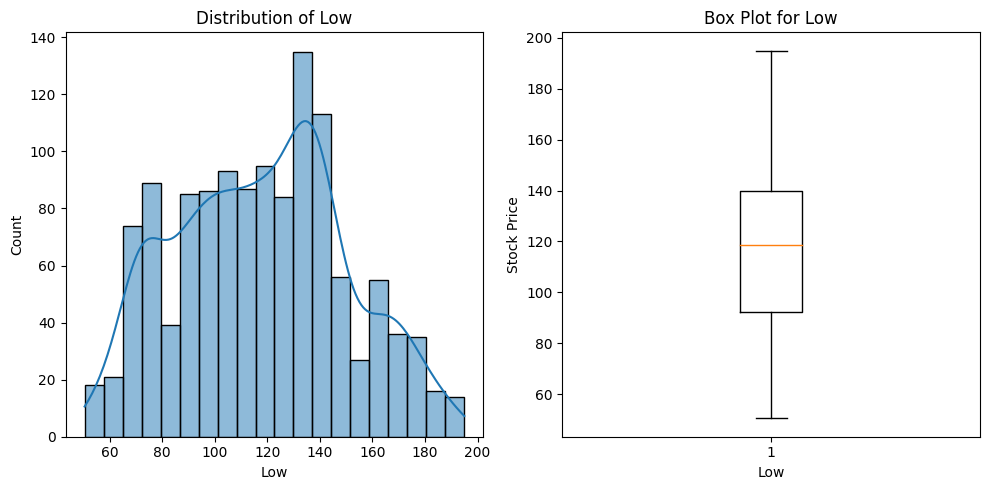

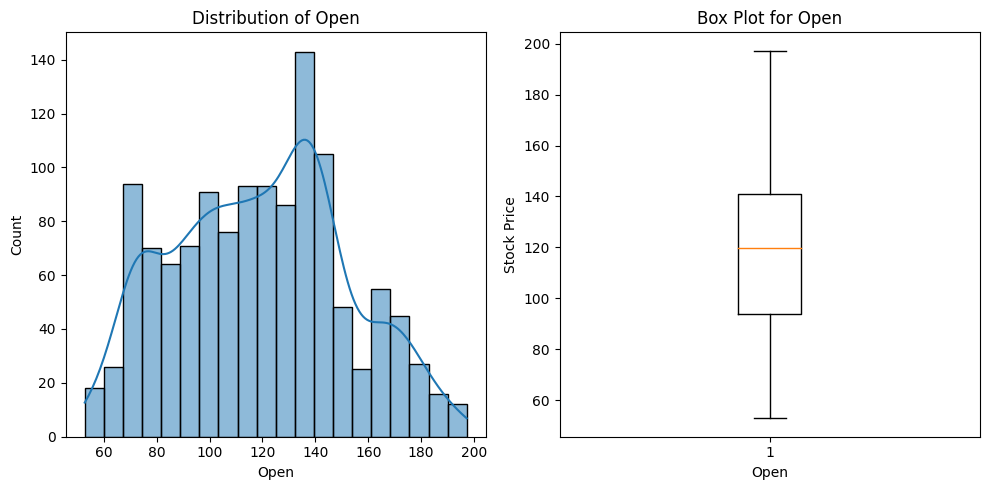

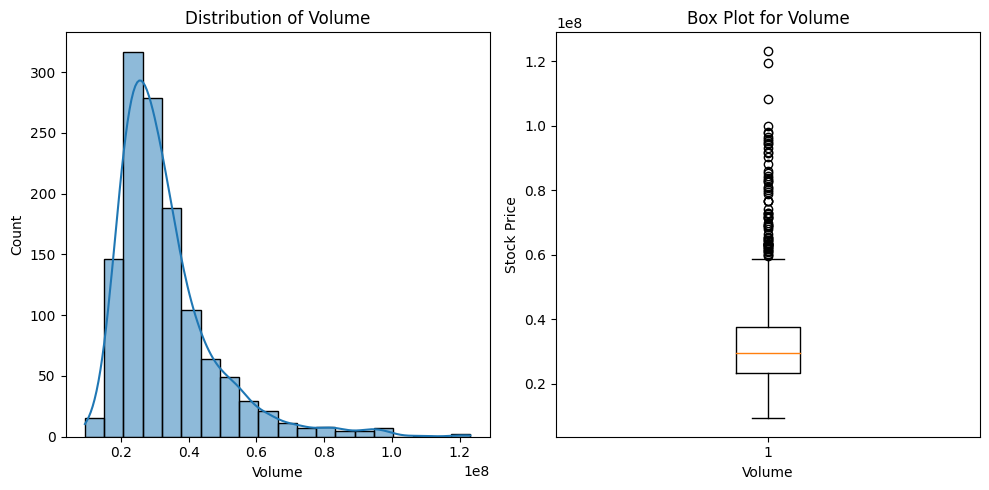

In [9]:
# Distribution of features
numeric_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
for col in numeric_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.histplot(data=google, x=col, kde=True, bins=20)
    plt.title(f"Distribution of {col}")

    plt.subplot(1,2,2)
    plt.boxplot(x=google[col])
    plt.title(f"Box Plot for {col}")
    plt.ylabel("Stock Price")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

### Outlier Analysis: Trading
We analyzed the trading volume (Volume) column in the dataset using the IQR (Interquartile Range) method and obtained the following results:

Total data points: 1258  
Outliers detected: 70 (5.56%)    

Minimum and maximum values of outliers:   
Minimum: 9,312,000   
Maximum: 123,200,000 (Clearly an extreme outlier!) 

**Should We Remove Outliers?**    
Outliers Are Important in Financial Data: Significant increases in trading volume are usually caused by major market movements, investor sentiment, or important news (e.g., earnings reports, major deals).     
Low Percentage of Outliers (5.56%): Since outliers only make up 5.56% of the dataset, removing them could make it harder to analyze major market movements.     
A More Logical Approach: Instead of removing all outliers, we could only eliminate extreme values (e.g., trading volumes above 100 million) for a better analysis.    

In [10]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = google['Volume'].quantile(0.25)
Q3 = google['Volume'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
upper_bound = Q3 + 1.5 * IQR
extreme_outliers = google[google['Volume'] > (upper_bound + 1.5 * IQR)]

# Count the number of outliers
count_extreme_outliers = extreme_outliers.shape[0]

print(f"Number of extreme outliers: {count_extreme_outliers}")

Number of extreme outliers: 25


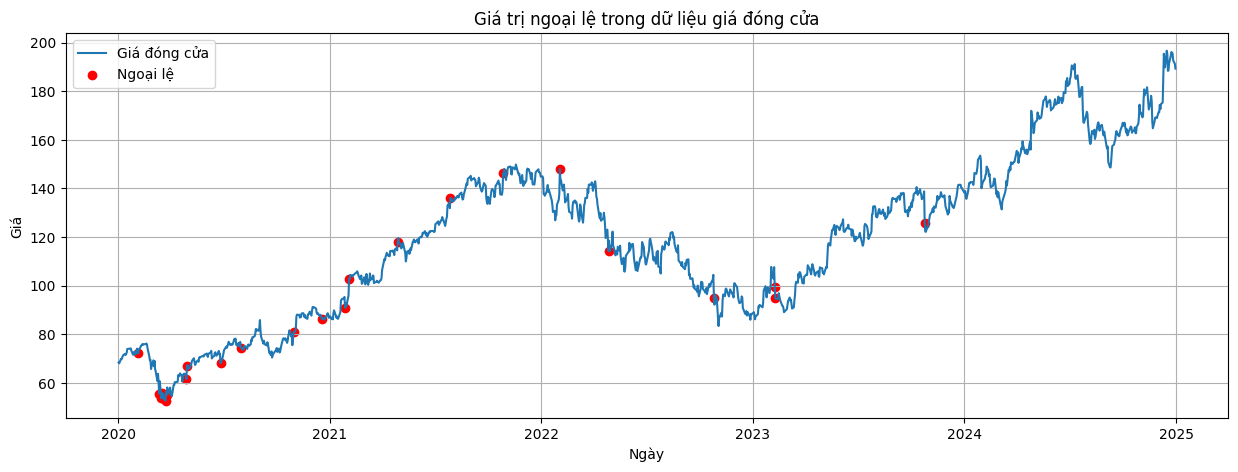

In [11]:
# Visualize extreme outliers
plt.figure(figsize=(15, 5))
plt.plot(google['Date'], google['Close'], label='Giá đóng cửa')
plt.scatter(extreme_outliers['Date'], extreme_outliers['Close'], color='red', label='Ngoại lệ')
plt.title('Giá trị ngoại lệ trong dữ liệu giá đóng cửa')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 0, 'Volume')

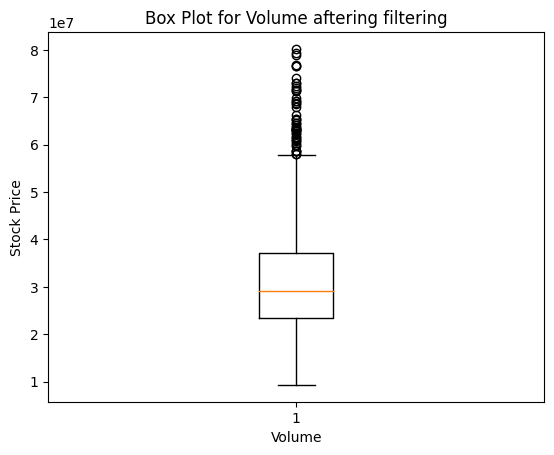

In [12]:
# Removing extreme outliers
google = google[google["Volume"] <= (upper_bound + 1.5 * IQR)]

# Visualize distribution of Volume aftering filtering
plt.boxplot(x=google['Volume'])
plt.title("Box Plot for Volume aftering filtering")
plt.ylabel("Stock Price")
plt.xlabel('Volume')

### Financial Analysis

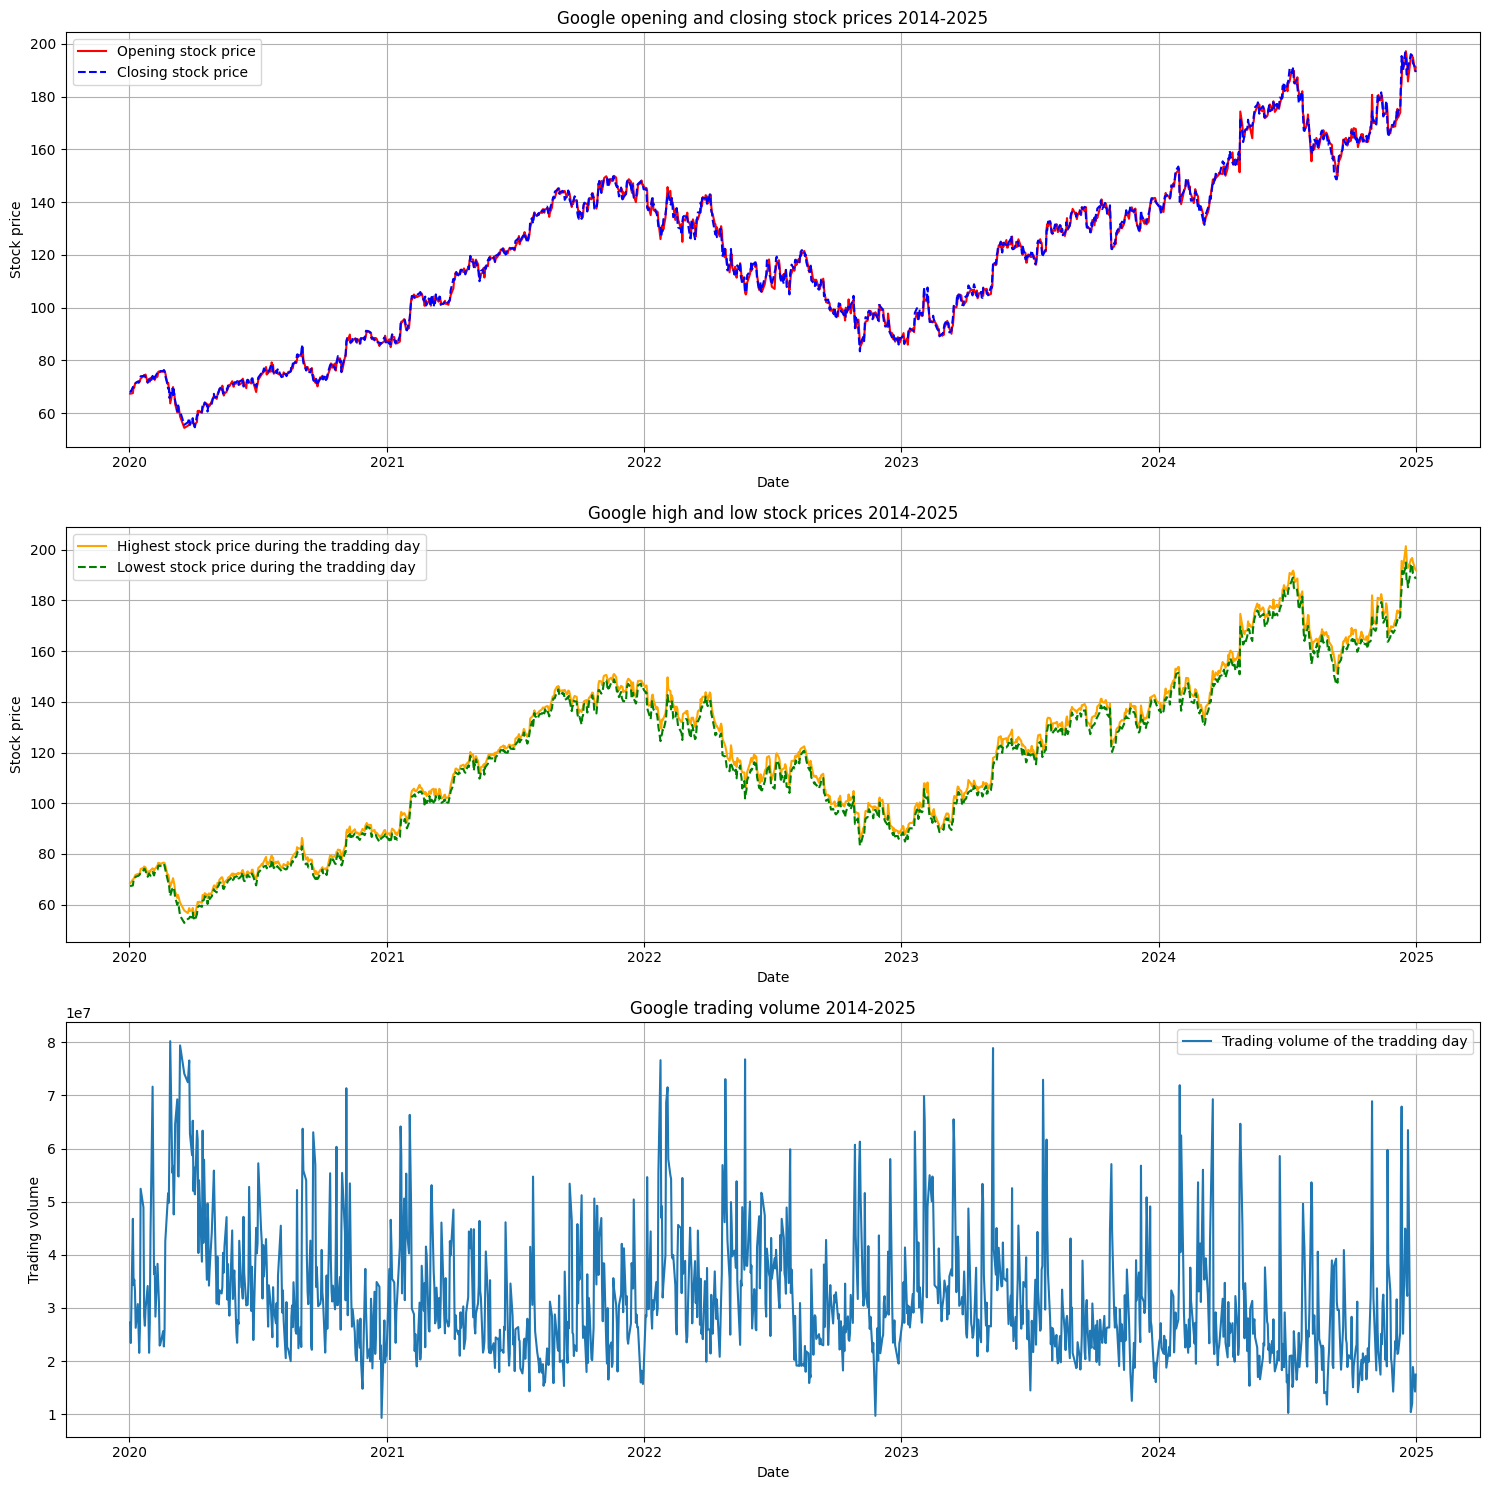

In [30]:
# Visualize Google stock price 2014 - 2025
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Opening and Close price
axs[0].plot(google['Date'], google['Open'], color='r', label ='Opening stock price')
axs[0].plot(google['Date'], google['Close'], color='b', linestyle="dashed", label ='Closing stock price')
axs[0].set_title('Google opening and closing stock prices 2014-2025')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Stock price')
axs[0].legend()
axs[0].grid()

# High and Low price
axs[1].plot(google['Date'], google['High'], color='orange', label ='Highest stock price during the tradding day')
axs[1].plot(google['Date'], google['Low'], color='g', linestyle="dashed", label ='Lowest stock price during the tradding day')
axs[1].set_title('Google high and low stock prices 2014-2025')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock price')
axs[1].legend()
axs[1].grid()

# Trading Volume
axs[2].plot(google['Date'], google['Volume'], label ='Trading volume of the tradding day')
axs[2].set_title('Google trading volume 2014-2025')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Trading volume')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

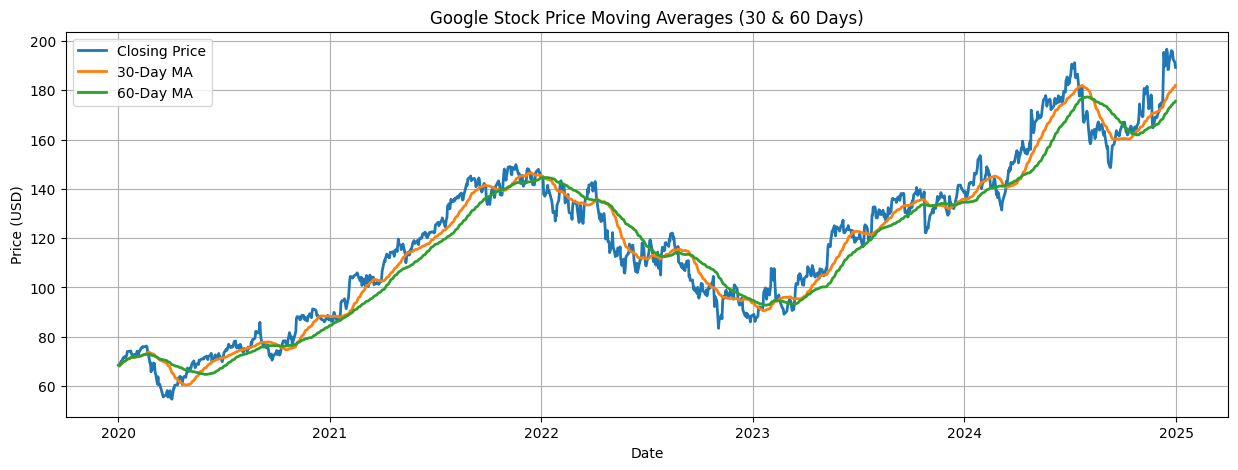

In [14]:
# Moving averages (Đường trung bình động - Đường nối tất cả mức giá đóng cửa trung bình)
google.loc[:, "Close_MA30"] = google["Close"].rolling(window=30, min_periods=1).mean()    # 30 ngày
google.loc[:, "Close_MA60"] = google["Close"].rolling(window=60, min_periods=1).mean()   # 60 ngày

plt.figure(figsize=(15, 5))
sns.lineplot(x=google['Date'], y=google["Close"], label="Closing Price", linewidth=2)
sns.lineplot(x=google['Date'], y=google["Close_MA30"], label="30-Day MA", linewidth=2)
sns.lineplot(x=google['Date'], y=google["Close_MA60"], label="60-Day MA", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Google Stock Price Moving Averages (30 & 60 Days)")
plt.legend()
plt.grid()
plt.show()

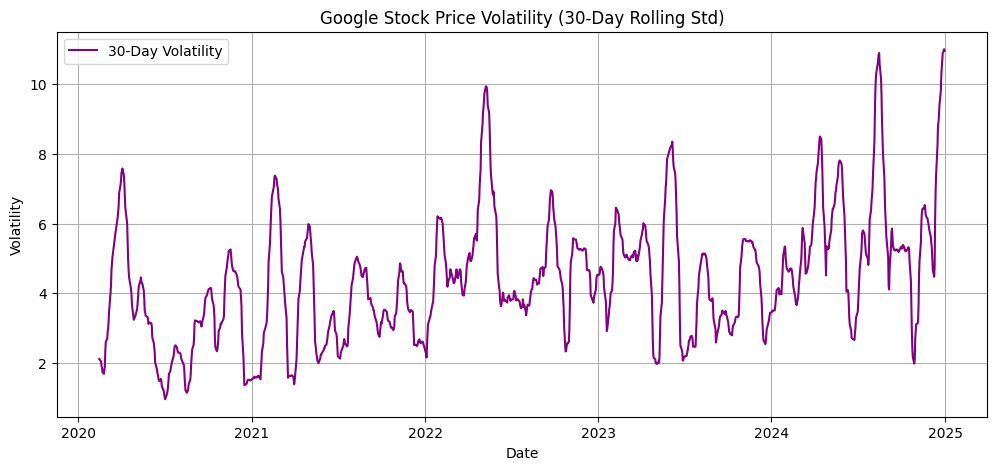

In [31]:
# Volatility (Độ biến Động - Độ lệch chuẩn của giá đóng cửa trong 30 ngày)
google["Volatility_30"] = google["Close"].rolling(window=30).std()  # 30 ngày

plt.figure(figsize=(12, 5))
plt.plot(google['Date'], google["Volatility_30"], label="30-Day Volatility", color='purple')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Google Stock Price Volatility (30-Day Rolling Std)")
plt.legend()
plt.grid()
plt.show()

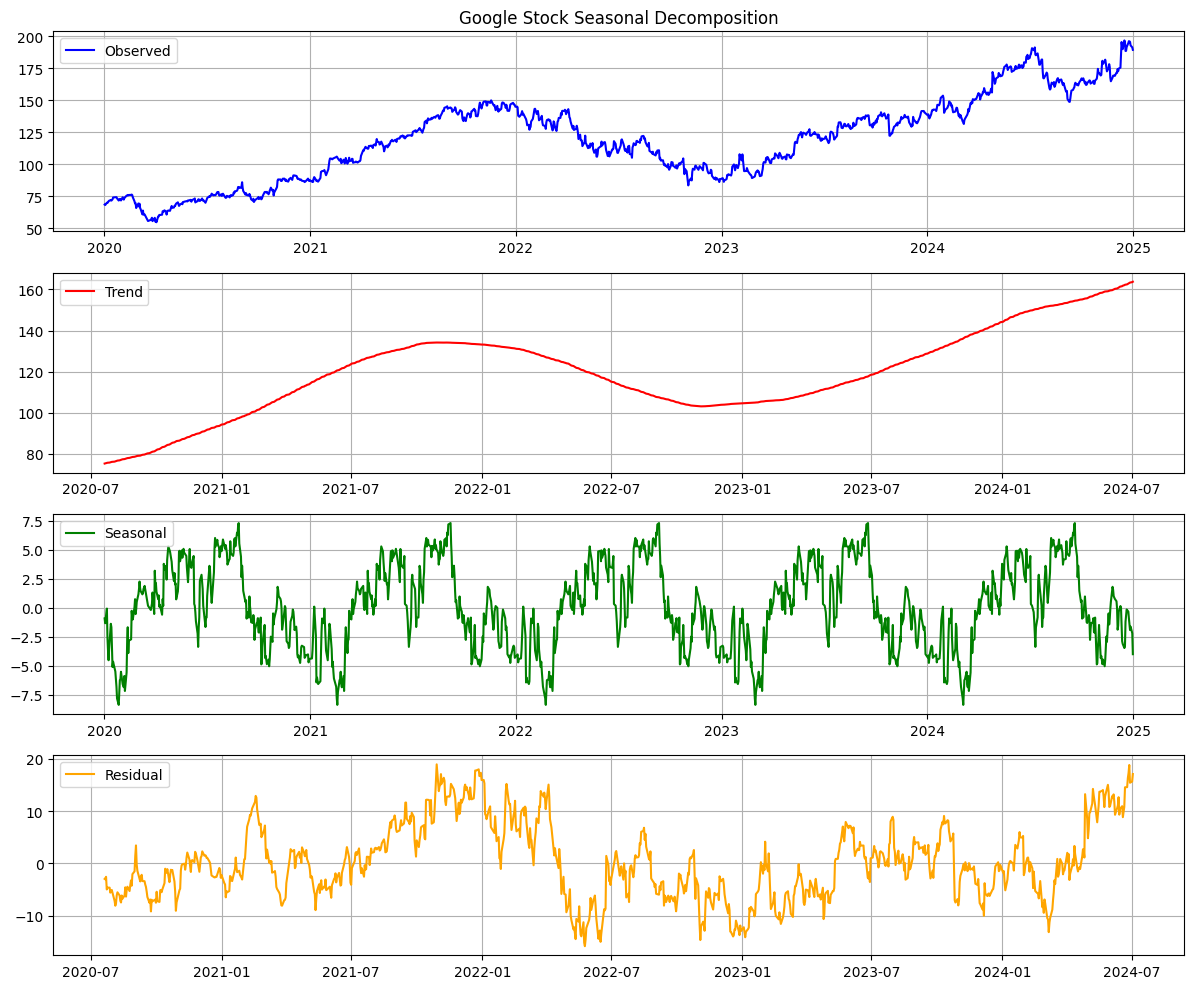

In [16]:
# Seasonal Decomposition (Phân tích tính thời vụ trên giá đóng cửa)
decomposition = seasonal_decompose(google["Close"], model="additive", period=252)   # 252 ngày giao dịch/năm

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.title("Google Stock Seasonal Decomposition")
plt.plot(google['Date'], decomposition.observed, label="Observed", color="blue")    # Observed (Dữ liệu gốc): Giá đóng cửa theo thời gian
plt.grid()
plt.legend()

plt.subplot(4, 1, 2) 
plt.plot(google['Date'], decomposition.trend, label="Trend", color="red")           # Trend (Xu hướng): Xu hướng dài hạn của giá cổ phiếu
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(google['Date'], decomposition.seasonal, label="Seasonal", color="green")   # Seasonal (Thời vụ): Biến động có tính chu kỳ hàng năm
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(google['Date'], decomposition.resid, label="Residual", color="orange")     # Residual (Phần dư): Phần không giải thích được bởi xu hướng và thời vụ
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

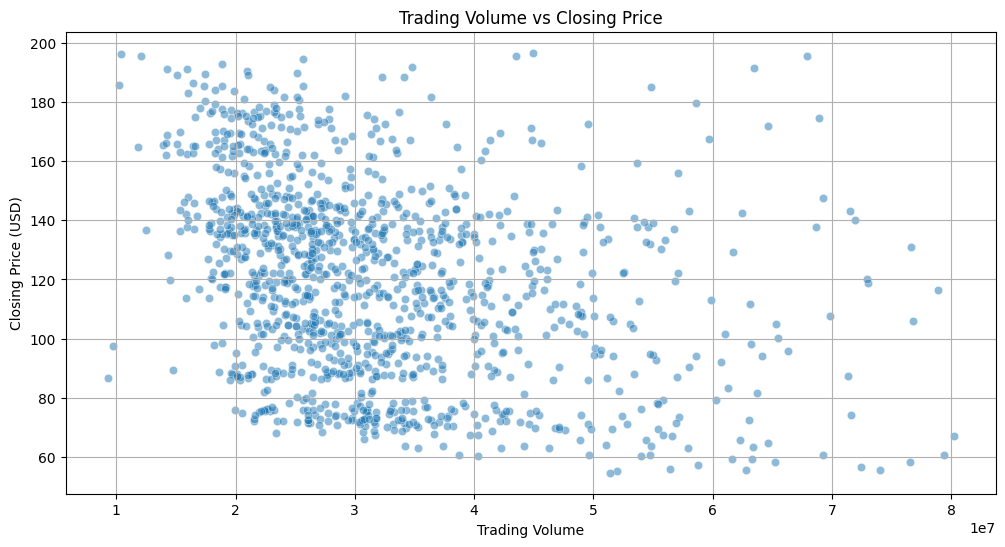

In [17]:
# Volume vs. Closing Price Scatter Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=google["Volume"], y=google["Close"], alpha=0.5)
plt.xlabel("Trading Volume")
plt.ylabel("Closing Price (USD)")
plt.title("Trading Volume vs Closing Price")
plt.grid()
plt.show()

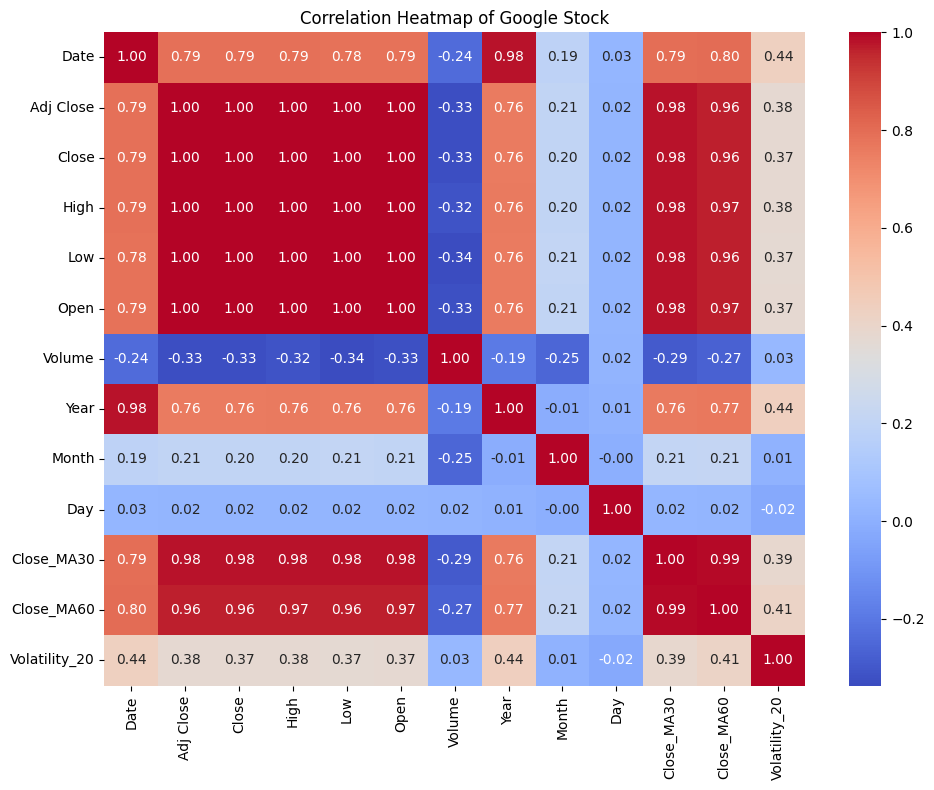

In [18]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = google.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Google Stock')
plt.tight_layout()
plt.show()

# Time Series Forcasting

In [ ]:
# Hưng

# XAI

In [ ]:
# Anh Duy